In [376]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [377]:
pair_name = "ICX/USDT"
exchange_name = "bitget"
type = "future"

exchange = None
if type == "spot":
    if exchange_name == "binance":
        exchange = ccxt.binance()
        pair = pair_name
        params = {}
        limit = 1000
    elif exchange_name == "bitget":
        exchange = ccxt.bitget()
        pair = pair_name
        params = {"type": "step2"}
        limit = 150
elif type == "future":
    if exchange_name == "binance":
        exchange = ccxt.binanceusdm()
        pair = pair_name
        limit = 1000
    elif exchange_name == "bitget":
        exchange = ccxt.bitget()
        pair = pair_name + ":USDT"
        params = {"type": "step2"}
        limit = 150

orderbook = exchange.fetch_order_book(pair, limit=limit, params=params)
best_ask = orderbook["asks"][0][0]
best_bid = orderbook["bids"][0][0]
mid_price = (best_bid + best_ask) / 2

bid_prices, bid_quantities = zip(
    *sorted(orderbook["bids"], key=lambda x: x[0], reverse=True)
)
ask_prices, ask_quantities = zip(*sorted(orderbook["asks"], key=lambda x: x[0]))

cumulative_bid_quantities = [
    sum(bid_quantities[: i + 1]) for i in range(len(bid_quantities))
]
cumulative_ask_quantities = [
    sum(ask_quantities[: i + 1]) for i in range(len(ask_quantities))
]
lower_price_limit = mid_price * 0.99  # -2%
upper_price_limit = mid_price * 1.01  # +2%

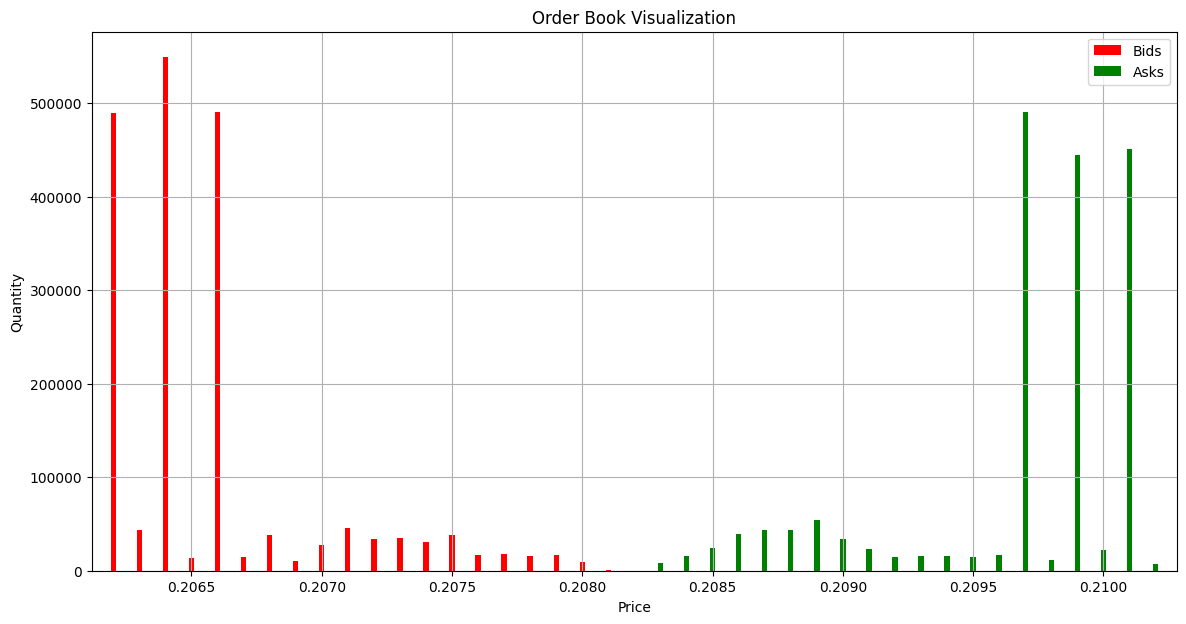

In [378]:
# Création du graphique
plt.figure(figsize=(14, 7))

width = mid_price / 10000

# Filtrer les données pour les 'bids' et 'asks' à afficher
filtered_bid_prices = [p for p in bid_prices if lower_price_limit <= p <= upper_price_limit]
filtered_bid_quantities = [q for p, q in zip(bid_prices, bid_quantities) if lower_price_limit <= p <= upper_price_limit]

filtered_ask_prices = [p for p in ask_prices if lower_price_limit <= p <= upper_price_limit]
filtered_ask_quantities = [q for p, q in zip(ask_prices, ask_quantities) if lower_price_limit <= p <= upper_price_limit]

# Tracer les 'bids'
plt.bar(filtered_bid_prices, filtered_bid_quantities, color='red', label='Bids', align='center', width=width)

# Tracer les 'asks'
plt.bar(filtered_ask_prices, filtered_ask_quantities, color='green', label='Asks', align='center', width=width)

plt.title('Order Book Visualization')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.legend()

# Définir les limites de l'axe des X pour restreindre l'affichage aux prix entre -2% et +2%
plt.xlim(lower_price_limit, upper_price_limit)

# Ajustements pour une meilleure lisibilité
plt.grid(True)          # Ajouter une grille pour améliorer la lisibilité

plt.show()

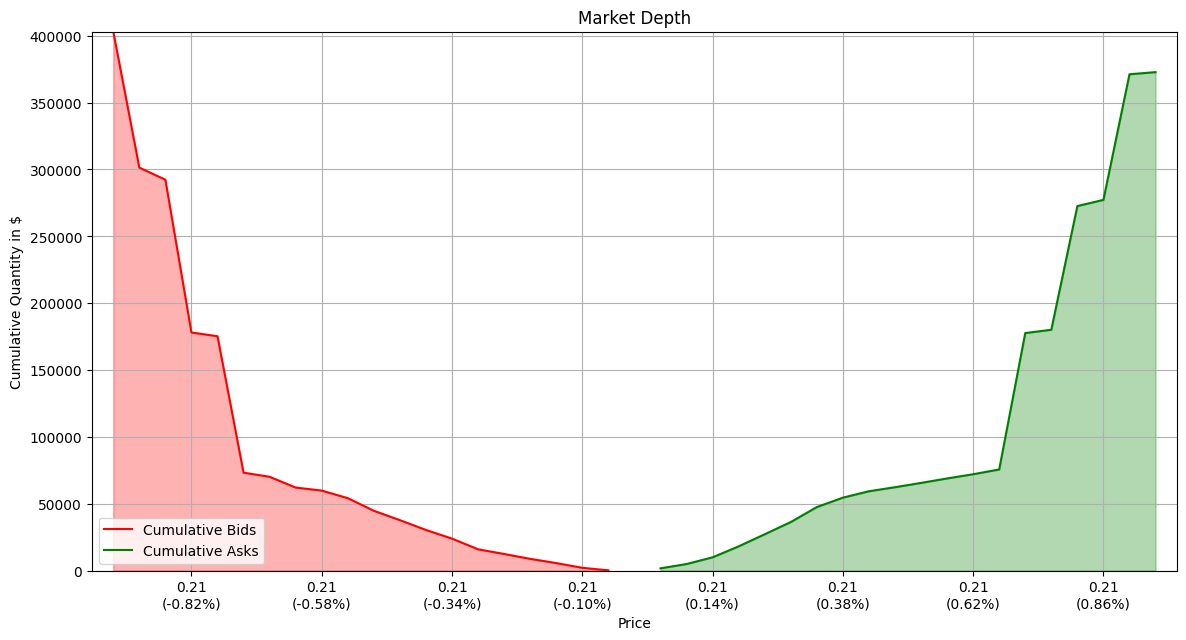

In [382]:
# Filtrer les données pour obtenir les quantités cumulatives dans la plage spécifiée
filtered_bid_prices = [p for p in bid_prices if lower_price_limit <= p <= upper_price_limit]
filtered_ask_prices = [p for p in ask_prices if lower_price_limit <= p <= upper_price_limit]
filtered_bid_quantities = [q for p, q in zip(bid_prices, [c * mid_price for c in cumulative_bid_quantities]) if lower_price_limit <= p <= upper_price_limit]
filtered_ask_quantities = [q for p, q in zip(ask_prices, [c * mid_price for c in cumulative_ask_quantities]) if lower_price_limit <= p <= upper_price_limit]

# Création du graphique
plt.figure(figsize=(14, 7))

# Tracer les courbes cumulatives pour les données filtrées
plt.plot(filtered_bid_prices, filtered_bid_quantities, color='red', label='Cumulative Bids')
plt.plot(filtered_ask_prices, filtered_ask_quantities, color='green', label='Cumulative Asks')

# Remplissage sous les courbes
plt.fill_between(filtered_bid_prices, 0, filtered_bid_quantities, color='red', alpha=0.3)
plt.fill_between(filtered_ask_prices, 0, filtered_ask_quantities, color='green', alpha=0.3)

plt.title('Market Depth')
plt.xlabel('Price')
plt.ylabel('Cumulative Quantity in $')
plt.legend()

# Définir les limites de l'axe des X et Y
plt.xlim(lower_price_limit, upper_price_limit)
plt.ylim(0, max(filtered_bid_quantities + filtered_ask_quantities))

# Configuration pour éviter la notation scientifique et ajouter des pourcentages sous les prix
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.2f}\n({(x - mid_price) / mid_price * 100:.2f}%)"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

plt.grid(True)
plt.show()

In [383]:
usd_to_execute = 10000
size_to_execute = round(usd_to_execute / (mid_price), 2)
# print(size_to_execute)
buy_market_filled = 0
sell_market_filled = 0
buy_execution_list = []
sell_execution_list = []
for i in range(len(orderbook["asks"])):
    current_buy_size = min(orderbook["asks"][i][1], size_to_execute - buy_market_filled)
    buy_market_filled += current_buy_size
    buy_execution_list.append({"price": orderbook["asks"][i][0], "size": current_buy_size})
    if buy_market_filled >= size_to_execute:
        break

for i in range(len(orderbook["bids"])):
    current_sell_size = min(orderbook["bids"][i][1], size_to_execute - sell_market_filled)
    sell_market_filled += current_sell_size
    sell_execution_list.append({"price": orderbook["bids"][i][0], "size": current_sell_size})
    if sell_market_filled >= size_to_execute:
        break

if buy_market_filled < size_to_execute:
    print("Not enough liquidity to buy")
if sell_market_filled < size_to_execute:
    print("Not enough liquidity to sell")

# print(buy_execution_list)
sell_market_price = sum([sell_execution["price"] * sell_execution["size"] for sell_execution in sell_execution_list]) / sum([sell_execution["size"] for sell_execution in sell_execution_list])
buy_market_price = sum([buy_execution["price"] * buy_execution["size"] for buy_execution in buy_execution_list]) / sum([buy_execution["size"] for buy_execution in buy_execution_list])
buy_pct_diff = ((buy_market_price - best_bid) / best_bid) * 100
sell_pct_diff = ((best_ask - sell_market_price) / sell_market_price) * 100
print(f"Market fees vs limit fees: {round(usd_to_execute * 0.0004, 2)}$")
print(f"Buy market price: {round(buy_market_price, 4)}$ vs Best bid: {round(best_bid, 4)}$, Theorical loss: - {round(buy_pct_diff, 3)} % (- {round(buy_pct_diff * usd_to_execute / 100, 2)}$)")
print(f"Sell market price: {round(sell_market_price, 4)}$ vs Best ask: {round(best_ask, 4)}$, Theorical loss: - {round(sell_pct_diff, 3)} % (- {round(sell_pct_diff * usd_to_execute / 100, 2)}$)")

Market fees vs limit fees: 4.0$
Buy market price: 0.2084$ vs Best bid: 0.2081$, Theorical loss: - 0.162 % (- 16.17$)
Sell market price: 0.2079$ vs Best ask: 0.2083$, Theorical loss: - 0.21 % (- 20.95$)
